In [1]:
# ============
# Make the HadCRUT4 SAT time series.
# ============
# Using infilled data from: https://www-users.york.ac.uk/~kdc3/papers/coverage2013/series.html
# ============

In [2]:
import netCDF4
import numpy as np
import os
import sys
#from numerics import find_nearest
import pickle
import glob
#from cmip import *  # This has various routines in such as make_ts_2d
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec

sys.path.insert(0, '/home/users/lfbor/python/scripts3/python_modules')
from cmip import *  # This has various routines in such as make_ts_2d

%matplotlib inline

basedir = '/home/users/lfbor/python/scripts3/PythonNotebooks/'
#/home/lfbor/python/notebooks/cmip6/output/

datadir = '/home/users/lfbor/data/'

hadcrut4_save_file = '/home/users/lfbor/data/HadCRUT4_time_series_regions.pkl'
hadcrut4_save_file_cmipformat_regridded = '/home/users/lfbor/data/HadCRUT4_AnnualMapCMIPStyleRegridded.pkl'
hadcrut4_save_file_cmipformat_regridded_djfm = '/home/users/lfbor/data/HadCRUT4_DJFMMapCMIPStyleRegridded.pkl'

regions = ['europe1', 'global', 'south_europe']

In [3]:
median_anom_file = os.path.join(datadir, 'HadCRUT.4.6.0.0.median.nc')
clim_file = os.path.join(datadir, 'absolute.nc')
infilled_file = os.path.join(datadir, 'had4sst4_krig_v2_0_0.nc')

(12, 36, 72) (36, 72) (36, 72) (36, 72)


/tmp/ipykernel_3320/3116467583.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon, lat, temperature_absolute_ann, vmin=-20, vmax=30)


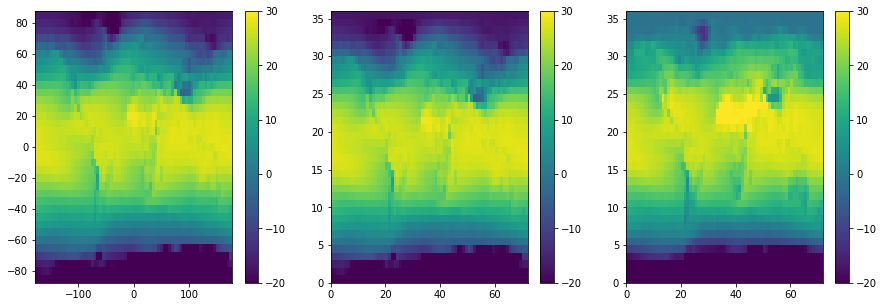

In [4]:
loaded = netCDF4.Dataset(clim_file)
temperature_absolute = loaded.variables['tem'][:]  # This has North at the bottom...
lat = loaded.variables['lat'][:]
lon = loaded.variables['lon'][:]

temperature_absolute = np.flip(temperature_absolute, axis=1)  # Now it doesn't
lat = np.flip(lat)

temperature_absolute_ann = temperature_absolute.mean(axis=0)
temperature_absolute_mam = temperature_absolute[[2, 3, 4], :, :].mean(axis=0)
temperature_absolute_jja = temperature_absolute[[5, 6, 7], :, :].mean(axis=0)

print(temperature_absolute.shape, temperature_absolute_ann.shape, temperature_absolute_mam.shape, temperature_absolute_jja.shape)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(lon, lat, temperature_absolute_ann, vmin=-20, vmax=30)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.pcolormesh(temperature_absolute_ann, vmin=-20, vmax=30)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.pcolormesh(temperature_absolute_jja, vmin=-20, vmax=30)
plt.colorbar()

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12]
(2028,) (2028, 36, 72) (36,) (72,) (2028,) (2028,)
[1850 1850 1850 1850 1850 1850 1850 1850 1850 1850 1850 1850 1851 1851
 1851 1851 1851 1851 1851 1851 1851 1851 1851 1851 1852 1852 1852 1852
 1852 1852]


/tmp/ipykernel_3320/1289112404.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(longitude, latitude, temperature[0, :, :], vmin=-8, vmax=4)


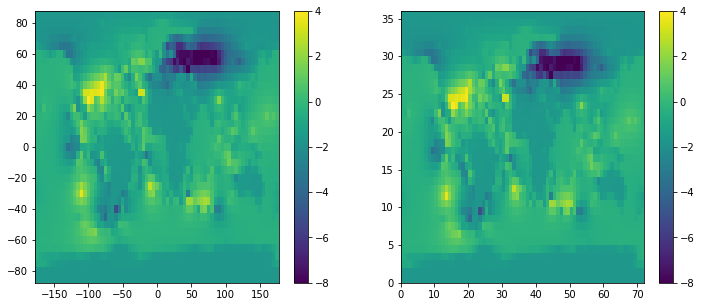

In [5]:
loaded = netCDF4.Dataset(infilled_file)
temperature = loaded.variables['temperature_anomaly'][:]
latitude = loaded.variables['latitude'][:]
longitude = loaded.variables['longitude'][:]
time = loaded.variables['time'][:]
year = loaded.variables['year'][:]
mon = loaded.variables['month'][:]

years, counts = np.unique(year, return_counts=True)
print(counts)

print(time.shape, temperature.shape, latitude.shape, longitude.shape, year.shape, mon.shape)
print(year[:30])


# Have a look at the data on the lat/lon grid and just raw
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(longitude, latitude, temperature[0, :, :], vmin=-8, vmax=4)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(temperature[0, :, :], vmin=-8, vmax=4)
plt.colorbar()

nyrs = len(years)
_, nj, ni = temperature.shape
temperature_ann = np.ma.masked_all(shape=(nyrs, nj, ni))
temperature_jja = np.ma.masked_all(shape=(nyrs, nj, ni))
for iyr, this_year in enumerate(years):
#     print iyr, this_year
    ind = np.argwhere(year == this_year)
    ind2 = np.argwhere(((year == this_year) & (mon >= 6)) & ((year == (this_year)) & (mon <= 8)))
    
    if len(ind) == 12:
        temperature_ann[iyr, :, :] = temperature[ind, :, :].mean(axis=0) + temperature_absolute_ann
        
    if len(ind2) == 3:
        temperature_jja[iyr, :, :] = temperature[ind2, :, :].mean(axis=0) + temperature_absolute_jja

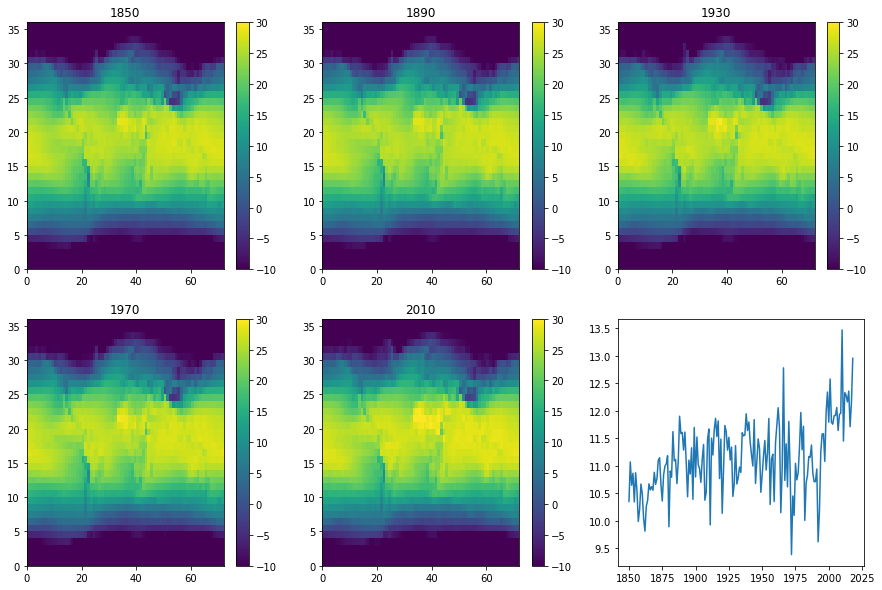

In [6]:
# Plot a selection of years
plt.figure(figsize=(15, 10))
for iyr in range(5):
    plt.subplot(2, 3, iyr+1)
    plt.pcolormesh(temperature_ann[iyr*40, :, :], vmin=-10, vmax=30)
    plt.colorbar()
    plt.title(years[iyr*40])
plt.subplot(2, 3, 6)
plt.plot(years, temperature_ann[:, 25, 45])

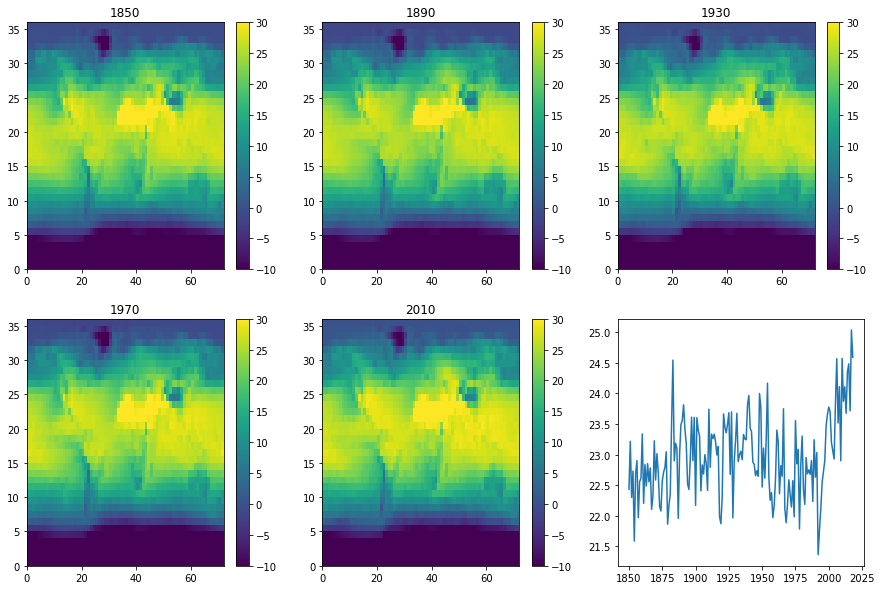

In [7]:
# plot a selection of seasons (the first one should be empty as there is no prior december)
plt.figure(figsize=(15, 10))
for iyr in range(5):
    plt.subplot(2, 3, iyr+1)
    plt.pcolormesh(temperature_jja[iyr*40, :, :], vmin=-10, vmax=30)
    plt.colorbar()
    plt.title(years[iyr*40])
plt.subplot(2, 3, 6)
plt.plot(years, temperature_jja[:, 25, 45])

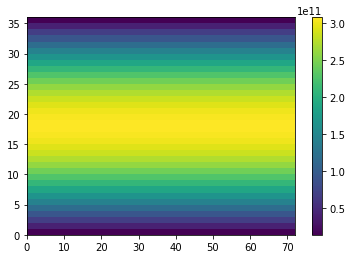

In [8]:
lon2d = np.repeat(lon[np.newaxis, :], nj, axis=0)
lat2d = np.repeat(lat[:, np.newaxis], ni, axis=1)

radius_earth = 6371229.
deg2rad = np.pi / 180.
dlon = 5.
dlat = 5.
area = np.ma.masked_all(shape=(nj, ni))
for jj in range(nj):
    area[jj, :] = (radius_earth ** 2.) * np.sin(deg2rad * dlat) * (np.sin(deg2rad * dlon) * np.cos(deg2rad * lat[jj]))
    
# check the area weights look sensible
plt.pcolormesh(area)
plt.colorbar()
plt.show()

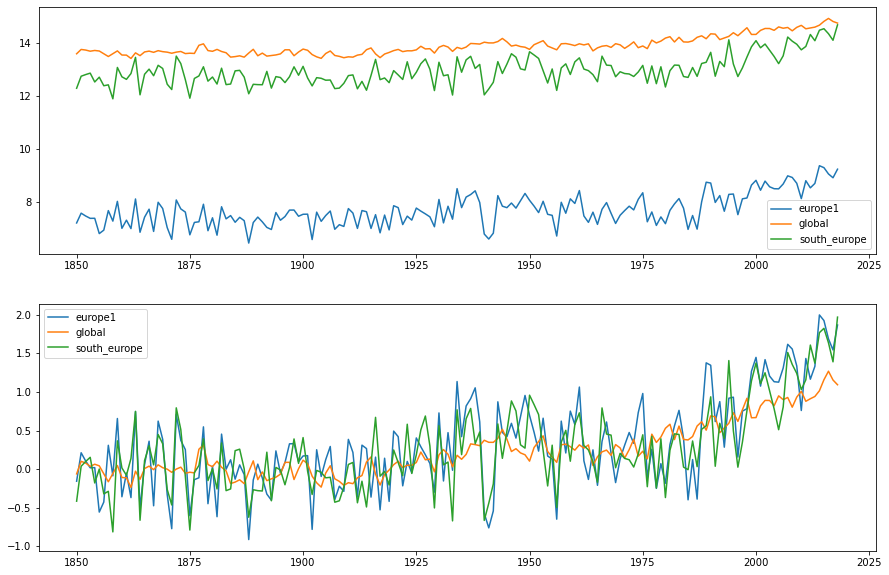

In [9]:
hadcrut4_ts = {}
for region in regions:
    hadcrut4_ts[region] = make_ts_2d(temperature_ann, lon2d, lat2d, area, region)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
for region in regions:
    plt.plot(years, hadcrut4_ts[region], label=region)
plt.legend()
plt.subplot(2, 1, 2)
for region in regions:
    plt.plot(years, hadcrut4_ts[region]-hadcrut4_ts[region][:30].mean(), label=region)
plt.legend()

In [12]:
# Save the time series
with open(hadcrut4_save_file, 'wb') as handle:
    # The zeros just mean that the dimensions end up being consistent with other files
    pickle.dump([0, hadcrut4_ts, 0, years], handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("DONE: time series written!")

DONE: time series written!


In [11]:
nj = 180
ni = 360
lon_re = np.repeat((np.arange(-180, 180) + 0.5)[np.newaxis, :], nj, axis=0)
lat_re = np.repeat((np.arange(-90, 90) + 0.5)[:, None], ni, axis=1)

radius_earth = 6.4e6
dlon = dlat = np.radians(1.)
area = np.ones(shape=(nj, ni))
for jj in range(nj):
    area[jj, :] *= radius_earth**2 * np.cos(np.radians(lat_re[jj])) * np.sin(dlon) * np.sin(dlat)

hadcrut4_regridded = np.ma.masked_all(shape=(len(years), nj, ni))

for tt in range(len(years)):
    print('Regridding map {:d}'.format(tt))
    hadcrut4_regridded[tt, :, :] = interpolate.griddata(np.array([lat2d.ravel(), lon2d.ravel()]).T,
                                                        temperature_ann[tt, :, :].ravel(), (lat_re, lon_re),
                                                        method='linear')
mask_regridded = interpolate.griddata(np.array([lat2d.ravel(), lon2d.ravel()]).T,
                                      temperature_ann[0, :, :].mask.ravel(), (lat_re, lon_re),
                                      method='linear')

hadcrut4_regridded = np.ma.array(hadcrut4_regridded, mask=np.repeat(mask_regridded[np.newaxis, :, :],
                                                                    len(years), axis=0))
area_regridded = np.ma.array(area, mask=mask_regridded)

Regridding map 0
Regridding map 1
Regridding map 2
Regridding map 3
Regridding map 4
Regridding map 5
Regridding map 6
Regridding map 7
Regridding map 8
Regridding map 9
Regridding map 10
Regridding map 11
Regridding map 12
Regridding map 13
Regridding map 14
Regridding map 15
Regridding map 16
Regridding map 17
Regridding map 18
Regridding map 19
Regridding map 20
Regridding map 21
Regridding map 22
Regridding map 23
Regridding map 24
Regridding map 25
Regridding map 26
Regridding map 27
Regridding map 28
Regridding map 29
Regridding map 30
Regridding map 31
Regridding map 32
Regridding map 33
Regridding map 34
Regridding map 35
Regridding map 36
Regridding map 37
Regridding map 38
Regridding map 39
Regridding map 40
Regridding map 41
Regridding map 42
Regridding map 43
Regridding map 44
Regridding map 45
Regridding map 46
Regridding map 47
Regridding map 48
Regridding map 49
Regridding map 50
Regridding map 51
Regridding map 52
Regridding map 53
Regridding map 54
Regridding map 55
Re

In [13]:
# Save the time series (again) but also the maps at the same time
with open(hadcrut4_save_file_cmipformat_regridded, 'wb') as handle:
    pickle.dump([hadcrut4_regridded, hadcrut4_ts, area_regridded, lon_re, lat_re, years], handle,
                protocol=pickle.HIGHEST_PROTOCOL)
    print "DONE!"

DONE!


In [15]:
# As above but for DJFM season
hadcrut4_djfm_regridded = np.ma.masked_all(shape=(len(years), nj, ni))

for tt in range(len(years)):
    print('Regridding map {:d}'.format(tt))
    if temperature_djfm[tt, :, :].mask.all():
        print "Skipping"
        continue
    hadcrut4_djfm_regridded[tt, :, :] = interpolate.griddata(np.array([lat2d.ravel(), lon2d.ravel()]).T,
                                                             temperature_djfm[tt, :, :].ravel(), (lat_re, lon_re),
                                                             method='linear')
mask_regridded = interpolate.griddata(np.array([lat2d.ravel(), lon2d.ravel()]).T,
                                      temperature_djfm[1, :, :].mask.ravel(), (lat_re, lon_re),
                                      method='linear')

hadcrut4_djfm_regridded = np.ma.array(hadcrut4_djfm_regridded,
                                      mask=np.repeat(mask_regridded[np.newaxis, :, :],len(years), axis=0))

with open(hadcrut4_save_file_cmipformat_regridded_djfm, 'wb') as handle:
    pickle.dump([hadcrut4_djfm_regridded, hadcrut4_ts, area_regridded, lon_re, lat_re, years], handle,
                protocol=pickle.HIGHEST_PROTOCOL)
    print "DONE!"

Regridding map 0
Skipping
Regridding map 1
Regridding map 2
Regridding map 3
Regridding map 4
Regridding map 5
Regridding map 6
Regridding map 7
Regridding map 8
Regridding map 9
Regridding map 10
Regridding map 11
Regridding map 12
Regridding map 13
Regridding map 14
Regridding map 15
Regridding map 16
Regridding map 17
Regridding map 18
Regridding map 19
Regridding map 20
Regridding map 21
Regridding map 22
Regridding map 23
Regridding map 24
Regridding map 25
Regridding map 26
Regridding map 27
Regridding map 28
Regridding map 29
Regridding map 30
Regridding map 31
Regridding map 32
Regridding map 33
Regridding map 34
Regridding map 35
Regridding map 36
Regridding map 37
Regridding map 38
Regridding map 39
Regridding map 40
Regridding map 41
Regridding map 42
Regridding map 43
Regridding map 44
Regridding map 45
Regridding map 46
Regridding map 47
Regridding map 48
Regridding map 49
Regridding map 50
Regridding map 51
Regridding map 52
Regridding map 53
Regridding map 54
Regridding 

Text(0.5,1,'Regridded')

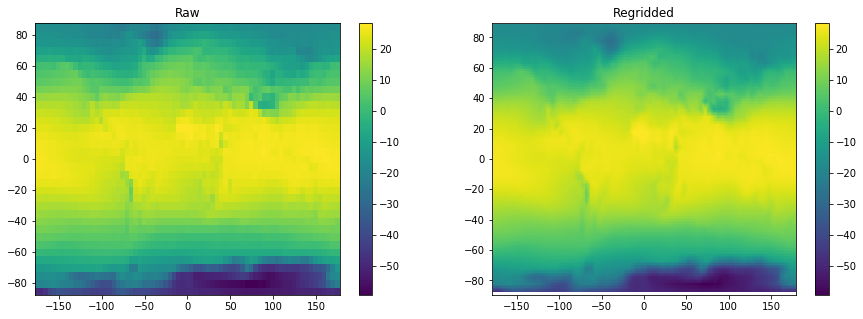

In [14]:
# Compare the raw and regridded data to check it is sensible
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.pcolormesh(lon, lat, temperature_ann[0, :, :])
plt.colorbar()
plt.title('Raw')

plt.subplot(1, 2, 2)
plt.pcolormesh(lon_re, lat_re, hadcrut4_regridded[0, :, :])
plt.colorbar()
plt.title('Regridded')